In [3]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Any, Dict, List
from google import genai
from google.genai.errors import APIError
from dotenv import load_dotenv
import time
import pickle
import importlib, figure_library
import warnings
warnings.filterwarnings("ignore")

In [4]:
df_raw = pd.read_csv(
    "wide_filled.csv"
)

df = df_raw.copy()
df["YEARWEEK"] = df["YEARWEEK"].astype(int)
df = df.sort_values("YEARWEEK")
s = df['YEARWEEK'].astype(str)

# Monday of each ISO year-week
df['week_start'] = pd.to_datetime(s + '1', format='%G%V%u')
train = df.iloc[260:468, 11].to_numpy()
test = df.iloc[468:520, 11].to_numpy()

df_half = df.copy()
df_half = df_half.iloc[len(df_half) // 2 :].reset_index(drop=True)

In [5]:
import pickle
with open("all_res.pkl", "rb") as f:
    GA_50 = pickle.load(f)
    
import numpy as np

# GA_50 is your list of 50 result dicts
n_runs = len(GA_50)          # should be 50
horizon = 52                 # desired length per run

# Initialize matrix with NaNs
all_preds = np.full((n_runs, horizon), np.nan, dtype=float)

for i, res in enumerate(GA_50):
    # --- get the raw text and its first non-space character ---
    raw = res.get("raw_texts", "")

    if isinstance(raw, str):
        text = raw
    elif isinstance(raw, (list, tuple)) and len(raw) > 0:
        # if raw_texts is a list, take the first element
        text = str(raw[0])
    else:
        text = ""

    # first non-whitespace character
    first_char = ""
    for ch in text.lstrip():
        first_char = ch
        break

    # we only use preds_mean if raw text starts with a number (digit)
    if first_char.isdigit():
        preds_mean = np.asarray(res["preds_mean"], dtype=float).ravel()

        # ensure exactly 52 entries: truncate if longer, pad with NaN if shorter
        L = min(preds_mean.size, horizon)
        all_preds[i, :L] = preds_mean[:L]
        # remaining entries (if any) stay as NaN
    # else: row stays all NaN

# all_preds is now a 50 x 52 numpy array


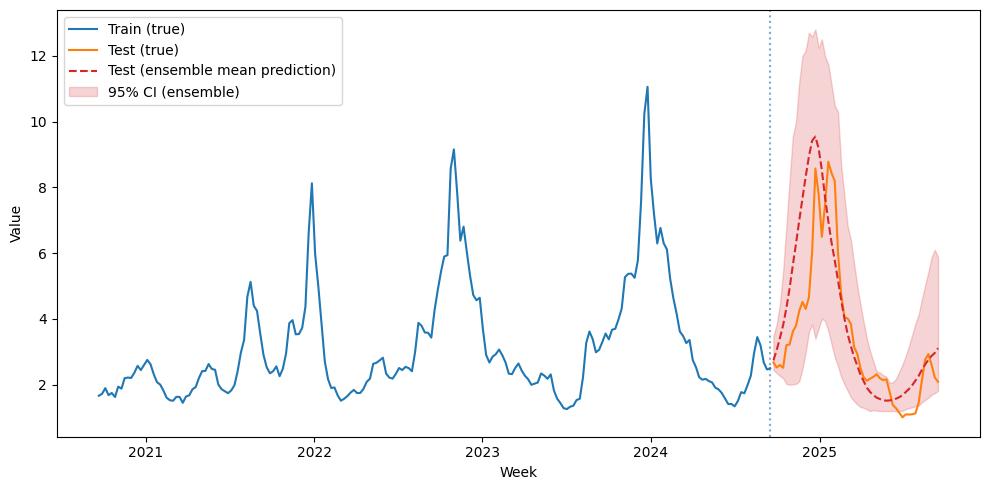

In [6]:
import importlib, figure_library
importlib.reload(figure_library)
from figure_library import gemini_forecast_plot_ensemble
fig, ax = gemini_forecast_plot_ensemble(
    train=train,
    test=test,
    preds=all_preds,      # shape (n_runs, len(test))
    time_points=df_half["week_start"],
	title = None,
	xlabel="Week",
    ylabel="Value"
)

#fig.savefig("gemini_forecast.pdf", bbox_inches="tight")
#plt.close(fig)

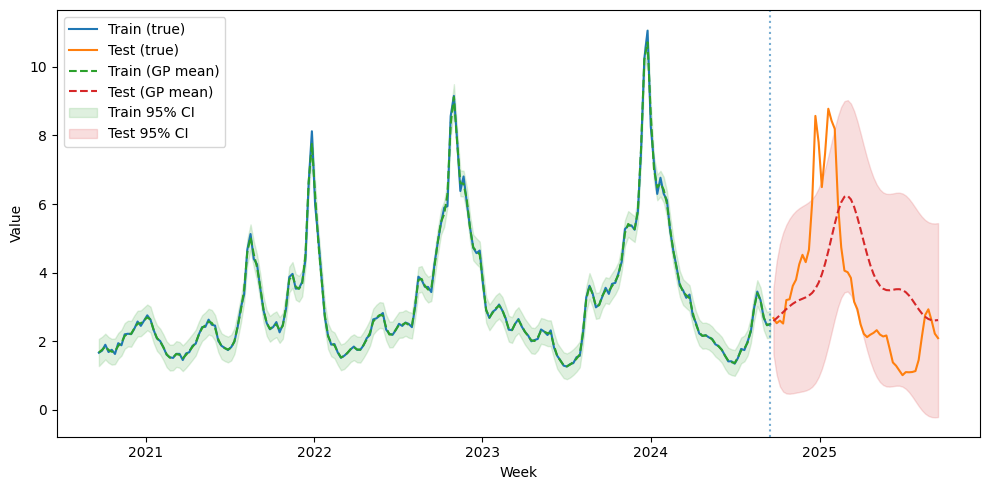

In [7]:
from figure_library import gp_forecast_plot, gp_forecast_fit
res = gp_forecast_fit(
    train, test,
    period_steps=52,         # yearly seasonality in weeks
    use_trend=True,          # include linear trend
    normalize=True,
    random_state=0,
    n_restarts=5,
	alpha = 0
)

fig, ax = gp_forecast_plot(
    res,
    time_points=df_half["week_start"],      # length = n_train + n_test
    xlabel="Week",
    ylabel="Value",
	title=None
)

#fig.savefig("gp_forecast.pdf", bbox_inches="tight")
#plt.close(fig)

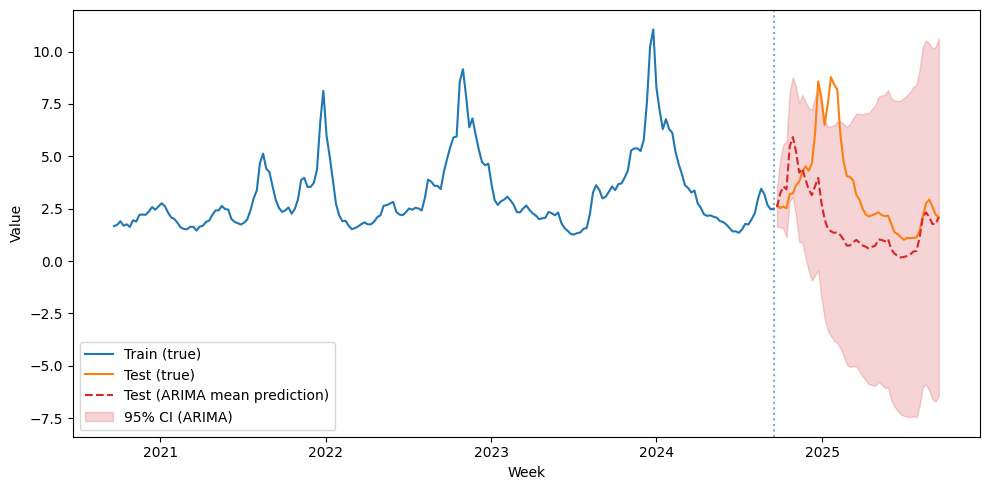

In [8]:
importlib.reload(figure_library)
from figure_library import arima_forecast
fig, ax = arima_forecast(
    train=train,
    test=test,
    time_points=df_half["week_start"],
    title=None,
    xlabel="Week",
    ylabel="Value",
)
#fig.savefig("arima_forecast.pdf", bbox_inches="tight")
#plt.close(fig)

In [9]:
importlib.reload(figure_library)
from figure_library import load_mae_matrix, load_gp_mae_matrix, load_arima_mae_matrix
p3_missing = load_mae_matrix("results_p3_missing.pkl.gz")
p2_missing = load_mae_matrix("results_p2_missing.pkl.gz")
p1_missing = load_mae_matrix("results_p1_missing.pkl.gz")
gp_missing = load_gp_mae_matrix("results_5_missing.pkl.gz")
arima_missing = load_arima_mae_matrix("arima_mae.csv")

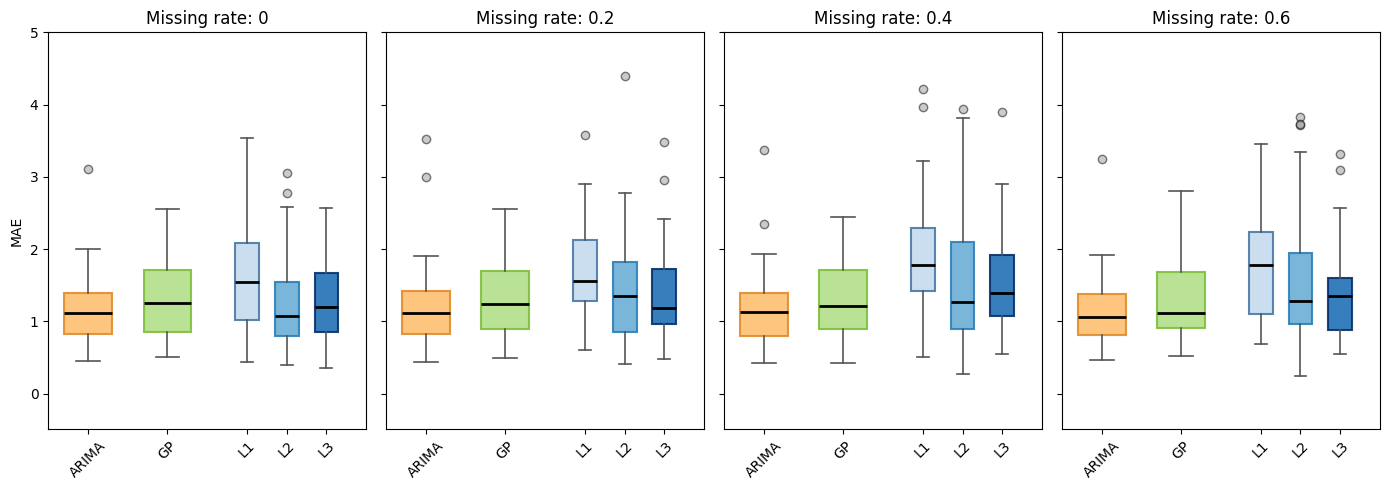

In [10]:
importlib.reload(figure_library)
from figure_library import plot_missing_rate_boxplots
matrices = [arima_missing, gp_missing, p1_missing, p2_missing, p3_missing]
method_names = ["ARIMA", "GP", "L1", "L2", "L3"]
missing_labels = ["0", "0.2", "0.4", "0.6"]

fig, axes = plot_missing_rate_boxplots(
    matrices,
    method_names,
    missing_labels,
    figsize=(14, 5),
    ylabel="MAE",
	y_max = 5
)

#fig.savefig("missing_compare.pdf", bbox_inches="tight")
#plt.close(fig)

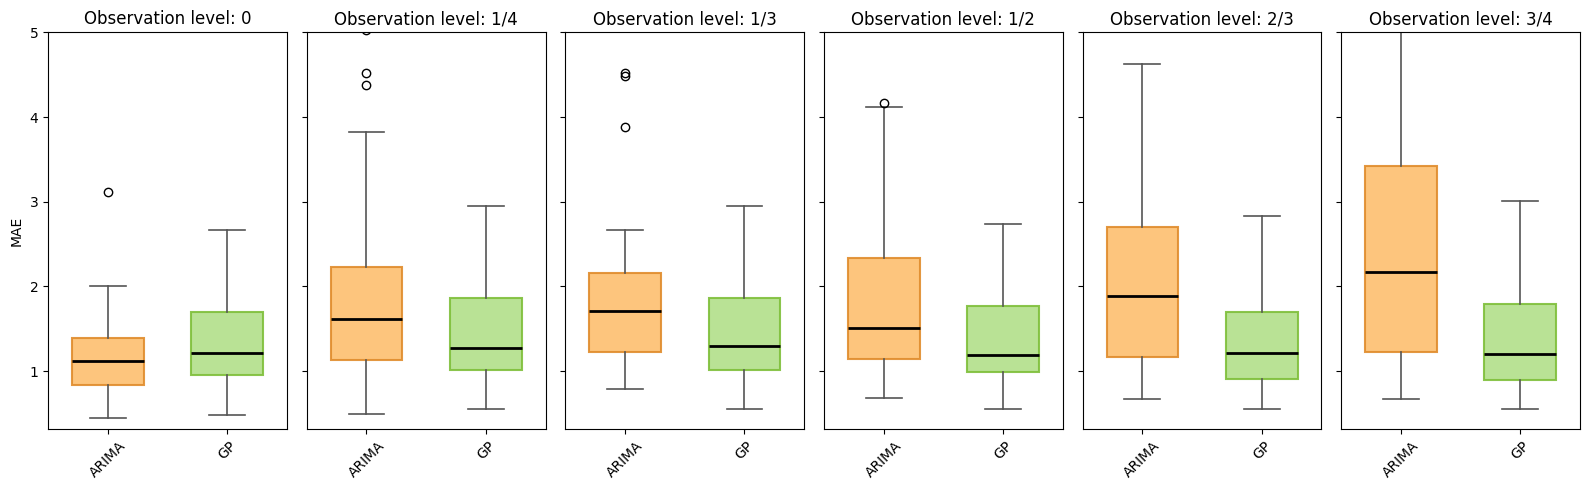

In [11]:
importlib.reload(figure_library)
from figure_library import load_gp_mae_matrix, load_arima_mae_observation, plot_observation_level_boxplots
observation_gp = load_gp_mae_matrix("results_5_w.pkl.gz", rows=(0, 1, 2, 3, 4, 5))
observation_arima = load_arima_mae_observation("observation_arima.csv")

matrices_obs = [observation_arima, observation_gp]
method_names = ["ARIMA", "GP"]
obs_labels = ["0", "1/4", "1/3", "1/2", "2/3", "3/4"]

fig, axes = plot_observation_level_boxplots(
    matrices_obs,
    method_names=method_names,
    obs_labels=obs_labels,
    figsize=(16, 5),
    ylabel="MAE",
    y_max=5,
)

#fig.savefig("observation_compare.pdf", bbox_inches="tight")
#plt.close(fig)